notes on 2020.1.8:
1. in the current Kakuho system, the threat score has reached 50% at one hour lead time

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

data_folder = "/Users/jiang/data/jma_radar/2020/01/07"
grib_files = glob.glob(os.path.join(data_folder,"*.000"))  # 288 = 12*24
print(len(grib_files))
grib_files.sort()

/Users/jiang/github_all/rainymotion/docs/notebooks
288


### read wgrib2 file into nc file

In [6]:
if False:  # only do it once
    var = "surface"
    for grib_file in grib_files:
        ncfile_name = grib_file.split("/")[-1].split(".")[0]+".nc"
        ncfile = os.path.join(data_folder,ncfile_name)
        cmd = f"wgrib2 {grib_file} -s | egrep '({var})'|wgrib2 -i {grib_file} -netcdf {ncfile}"
        fail = os.system(cmd)  # 0 indicate success, others indicate fail
        if fail:
            print("wgrib2 wrong at ",grib_file)

### check rain coverage in Honshu
- shows on 2020-1-7, rain coverage is less than 5%

In [8]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
print(len(nc_files))
nc_files.sort()

288


In [ ]:
from netCDF4 import Dataset
from datetime import datetime,timedelta
honshu_rain = []
threshold = 0.1 #  mm/h
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled().astype('float16')
    honshu_rain.append(np.sum(rain_filled >= threshold)/1e6)  # total pixels in one image is 1000*1000


In [53]:
dt = datetime(1970, 1, 1) + timedelta(seconds = root['time'][0].compressed()[0])
date_string = dt.strftime('%Y-%m-%d %H:%M UTC ')
print(date_string)

2020-01-07 23:55 UTC 


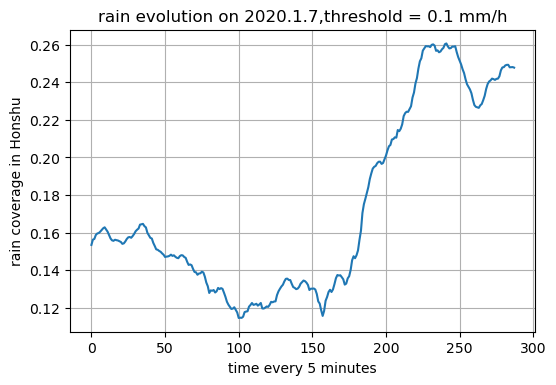

In [11]:
plt.figure(dpi=100)
plt.plot(honshu_rain)
plt.xlabel("time every 5 minutes")
plt.ylabel("rain coverage in Honshu")
plt.title(f"rain evolution on 2020.1.7,threshold = {threshold} mm/h")
plt.grid()
plt.show()

## compare rainymotion sparse mode, dense mode and persistence
- threat score

In [12]:
from rainymotion import models, metrics, utils
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt
import wradlib.ipol as ipol
%matplotlib inline
from netCDF4 import Dataset

In [13]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
nc_files.sort()

In [14]:
all_data = [] # 288 arrays with shape (1000,1000)
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled()
    all_data.append(rain_filled) 

In [15]:
now = 1
#threshold = 1  # mm/h

for now in range(1,270,12):  # every hour 
    hh = str(now * 5 // 60).zfill(2) 
    mm = str(now * 5  % 60).zfill(2)
    print(f"now = -{hh}:{mm}")
    
    inputs = np.array([all_data[now-1],all_data[now]])
    
    # SparseSD mode
    model = models.SparseSD()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    
    sparse_13_th = []
    sparse_13_re = []
    sparse_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold)
        sparse_13_th.append( hits / (hits + misses + falsealarms))
        sparse_13_re.append( hits / (hits + misses))
        sparse_13_pr.append( hits / (hits + falsealarms))
    
    # Dense mode
    model = models.Dense()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    dense_13_th = []  # threat score
    dense_13_re = []  # recall
    dense_13_pr = []  # precision
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold)
        dense_13_th.append( hits / (hits + misses + falsealarms))
        dense_13_re.append( hits / (hits + misses))
        dense_13_pr.append( hits / (hits + falsealarms))
        #dense_12.append(metrics.CSI(all_data[now+1+i],nowcast[i], threshold = 1))

    # persistance    
    persist_13_th = []
    persist_13_re = []
    persist_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now+i],all_data[now], threshold = threshold)
        persist_13_th.append( hits / (hits + misses + falsealarms))
        persist_13_re.append( hits / (hits + misses))
        persist_13_pr.append( hits / (hits + falsealarms))

    plt.figure(dpi = 100)
    lead_time = list(range(0,65,5))
    plt.plot(lead_time, dense_13_th, '-*', label = "dense")
    plt.plot(lead_time, sparse_13_th, '-s',label = "sparse")
    plt.plot(lead_time, persist_13_th, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("threat score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2020.1.7-{hh}:{mm},rainymotion+opencv,threshold = {threshold} mm/h")
    plt.grid()
    plt.savefig("JMA_rainymotion_th" + str(now).zfill(3) + ".png",format = "png")
    plt.close()

now = 2019.1.1-00:05


/Users/jiang/anaconda3/envs/rainymotion/lib/python3.8/site-packages/wradlib/ipol.py:368: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / self.dists ** self.p


now = 2019.1.1-01:05
now = 2019.1.1-02:05
now = 2019.1.1-03:05
now = 2019.1.1-04:05
now = 2019.1.1-05:05
now = 2019.1.1-06:05
now = 2019.1.1-07:05
now = 2019.1.1-08:05
now = 2019.1.1-09:05
now = 2019.1.1-10:05
now = 2019.1.1-11:05
now = 2019.1.1-12:05
now = 2019.1.1-13:05
now = 2019.1.1-14:05
now = 2019.1.1-15:05
now = 2019.1.1-16:05
now = 2019.1.1-17:05
now = 2019.1.1-18:05
now = 2019.1.1-19:05
now = 2019.1.1-20:05
now = 2019.1.1-21:05
now = 2019.1.1-22:05


### compare threat/recall/precision changes over in 5,10,15..60 minutes for 24 hours

In [ ]:
%%time
#now = 100
#threshold = 1  # mm/h

for now in range(1,270,12):  # every hour 
    hh = str(now * 5 // 60).zfill(2) 
    mm = str(now * 5  % 60).zfill(2)
    print(f"now = 2019.1.1-{hh}:{mm}")
    
    inputs = np.array([all_data[now-1],all_data[now]])
    
    # SparseSD mode
    model = models.SparseSD()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    
    sparse_13_th = []
    sparse_13_re = []
    sparse_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold)
        sparse_13_th.append( hits / (hits + misses + falsealarms))
        sparse_13_re.append( hits / (hits + misses))
        sparse_13_pr.append( hits / (hits + falsealarms))
    
    # Dense mode
    model = models.Dense()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    dense_13_th = []  # threat score
    dense_13_re = []  # recall
    dense_13_pr = []  # precision
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold)
        dense_13_th.append( hits / (hits + misses + falsealarms))
        dense_13_re.append( hits / (hits + misses))
        dense_13_pr.append( hits / (hits + falsealarms))
        #dense_12.append(metrics.CSI(all_data[now+1+i],nowcast[i], threshold = 1))

    # persistance    
    persist_13_th = []
    persist_13_re = []
    persist_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now+i],all_data[now], threshold = threshold)
        persist_13_th.append( hits / (hits + misses + falsealarms))
        persist_13_re.append( hits / (hits + misses))
        persist_13_pr.append( hits / (hits + falsealarms))

    lead_time = list(range(0,65,5))    
        
    plt.figure(dpi = 100)
    plt.plot(lead_time, dense_13_th, '-*', label = "dense")
    plt.plot(lead_time, sparse_13_th, '-s',label = "sparse")
    plt.plot(lead_time, persist_13_th, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("threat score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2020.1.7-{hh}:{mm},rainymotion+opencv,threshold = {threshold} mm/h")
    plt.grid()
    plt.savefig("JMA_rainymotion_th" + str(now).zfill(3) + ".png",format = "png")
    plt.close()
    
    plt.figure(dpi = 100)
    plt.plot(lead_time, dense_13_re, '-*', label = "dense")
    plt.plot(lead_time, sparse_13_re, '-s',label = "sparse")
    plt.plot(lead_time, persist_13_re, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("recall score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2020.1.7-{hh}:{mm},rainymotion+opencv,threshold = {threshold} mm/h")
    plt.grid()
    plt.savefig("JMA_rainymotion_re" + str(now).zfill(3) + ".png",format = "png")
    plt.close()
    
    plt.figure(dpi = 100)
    plt.plot(lead_time, dense_13_pr, '-*', label = "dense")
    plt.plot(lead_time, sparse_13_pr, '-s',label = "sparse")
    plt.plot(lead_time, persist_13_pr, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("precision score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2020.1.7-{hh}:{mm},rainymotion+opencv,threshold = {threshold} mm/h")
    plt.grid()
    plt.savefig("JMA_rainymotion_pr" + str(now).zfill(3) + ".png",format = "png")
    plt.close()

### make gif animiation and delete png images

In [45]:
import imageio
png_files = glob.glob("./JMA_rainymotion_th*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
output_file = 'JMA_rainymotion_threat-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds


23


In [46]:
import imageio
png_files = glob.glob("./JMA_rainymotion_re*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
output_file = 'JMA_rainymotion_recall-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds


23


In [47]:
import imageio
png_files = glob.glob("./JMA_rainymotion_pr*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
output_file = 'JMA_rainymotion_precision-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

23


##  compare ground truth image and nowcast image

In [19]:
from rainymotion import utils
data_scaled, c1, c2 = utils.RYScaler(np.array(all_data))  # shape(288,1000,1000)
nowcast_scaled, c3,c4 = utils.RYScaler(np.array(nowcast))
data_rescaled= utils.inv_RYScaler(data_scaled,c1,c2)  # shape(288,1000,1000)

In [23]:
now

265

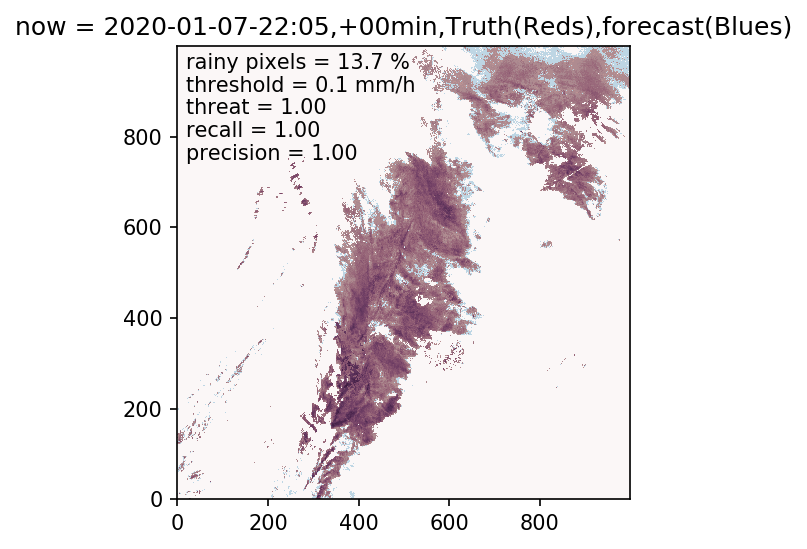

In [54]:
# one image
i = 0
dt = datetime(1970, 1, 1) + timedelta(seconds = root['time'][0].compressed()[0])
date_string = dt.strftime('%Y-%m-%d')

plt.figure(dpi = 150)
image1 = data_scaled[now+i]
image2 = nowcast_scaled[i]
plt.imshow(np.log(image1+0.01),cmap = 'Reds',origin = "lower")
plt.imshow(np.log(image2+0.01),cmap = 'Blues',origin = "lower",alpha = 0.5)
plt.title(f"now = {date_string}-{hh}:{mm},+{str(i*5).zfill(2)}min,Truth(Reds),forecast(Blues)")
plt.text(20, 950, f"rainy pixels = {np.sum(image1>1)/1e4:.1f} %")
plt.text(20, 900, f"threshold = {threshold} mm/h")
plt.text(20, 850, f"threat = {dense_13_th[i]:.2f}")
plt.text(20, 800, f"recall = {dense_13_re[i]:.2f}")
plt.text(20, 750, f"precision = {dense_13_pr[i]:.2f}")

plt.show()

In [55]:
dt = datetime(1970, 1, 1) + timedelta(seconds = root['time'][0].compressed()[0])
date_string = dt.strftime('%Y-%m-%d')
for i in range(13):
    plt.figure(dpi = 150)
    image1 = data_scaled[now+i]
    image2 = nowcast_scaled[i]
    plt.imshow(np.log(image1+0.01),cmap = 'Reds',origin = "lower")
    plt.imshow(np.log(image2+0.01),cmap = 'Blues',origin = "lower",alpha = 0.5)
    plt.title(f"now = {date_string}-{hh}:{mm},+{str(i*5).zfill(2)}min,Truth(Reds),forecast(Blues)")
    plt.text(20, 950, f"rainy pixels = {np.sum(image1>1)/1e4:.1f} %")
    plt.text(20, 900, f"threshold = {threshold} mm/h")
    plt.text(20, 850, f"threat = {dense_13_th[i]:.2f}")
    plt.text(20, 800, f"recall = {dense_13_re[i]:.2f}")
    plt.text(20, 750, f"precision = {dense_13_pr[i]:.2f}")
    plt.grid()
    plt.savefig("JMA_rainymotion_image_score" + str(i).zfill(2) + ".png",format = "png")
    plt.close()

In [57]:
import imageio
png_files = glob.glob("./JMA_rainymotion_image_score*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
output_file = f'JMA_rainymotion_image_score-{date_string}.gif'
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

13
